In [1]:
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
mnist_df = pd.read_csv('https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv', sep=',', header=None)

mnist_df = mnist_df.reindex(np.random.permutation(mnist_df.index))
mnist_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
4059,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18894,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13642,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15795,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6691,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6143,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3515,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1483,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3479,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
mnist_df.loc[:,0:1]

,0,1
4059,9,0
18894,7,0
13642,1,0
15795,7,0
6691,8,0
6143,9,0
3515,5,0
1483,3,0
3479,6,0
5878,0,0


In [4]:
#Extract labels and features
def parse_labels_and_features(dataset):
    #separate column 0 (label) and features
    labels = dataset[0]
    
    #Dataframe.loc index range are inclusive at both ends
    features = dataset.loc[:, 1:784]
    #Scale the data to [0,1] by diving out the max value, 255
    features = features/255
    
    return labels, features

In [5]:
training_targets, training_examples = parse_labels_and_features(mnist_df.head(16000))
display.display(training_examples.describe())
validation_targets, validation_examples = parse_labels_and_features(mnist_df.tail(4000))
display.display(validation_examples.describe())

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,16000.0,16000.0,16000.0,16000.0,16000.0,16000.0,16000.0,16000.0,16000.0,16000.0,...,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.0,16000.0,16000.0,16000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000910,0.000382,0.000179,0.000056,0.000100,0.000014,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026064,0.016319,0.011892,0.003950,0.009209,0.001798,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992157,0.996078,0.992157,0.309804,0.996078,0.227451,0.0,0.0,0.0,0.0


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,...,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.0,4000.0,4000.0,4000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000575,0.000191,0.0,0.000042,0.000239,0.000061,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018679,0.010828,0.0,0.002666,0.015129,0.003844,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992157,0.682353,0.0,0.168627,0.956863,0.243137,0.0,0.0,0.0,0.0


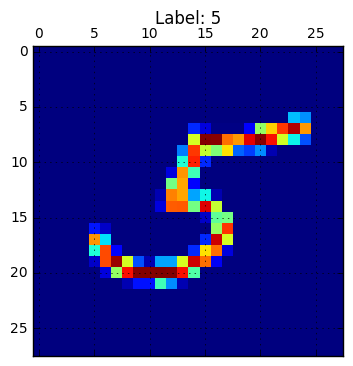

In [6]:
#Show a randome example and its corresponding label
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28,28))
ax.set_title('Label: %i' % training_targets.loc[rand_example])
ax.grid(True)
plt.show()

Build a Linear Model for MNIST

In [7]:
def construct_feature_columns():
    #Construct the TF Feature columns
    #There are 784 pixels in each image
    return set([tf.feature_column.numeric_column('pixels', shape=784)])

In [8]:
#Make separate input functions for training and for prediction
#Nest them in create_training_input_function() and create_predict_input_function()
def create_training_input_function(features, labels, batch_size, num_epochs=None, shuffle=True):
    #A custom input_fn for sending MNIST data to the estimator for training
    #Return: A function that returns batches of training features and labels during training
    def _input_function(num_epochs=None, shuffle=True):
        index = np.random.permutation(features.index)
        raw_features = {'pixels':features.reindex(index)}
        raw_targets = np.array(labels[index])
        
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size).repeat(num_epochs)
        
        if shuffle:
            ds = ds.shuffle(10000)
        
        #Return the next batch of data
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_function

In [9]:
def create_predict_input_function(features, labels, batch_size):
    #A custom input_fn for sending MNIT data to the estimator for predictions
    #Return: A function that return features and labels for predictions
    def _input_function():
        raw_features = {'pixels': features.values}
        raw_targets = np.array(labels)
        
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size)
        
        #Return the next batch of data
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_function

In [10]:
def train_linear_classification_model(
    my_optimizer,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps/periods
    
    #Create the input function
    training_input_function = create_training_input_function(training_examples, training_targets, batch_size)
    predict_training_input_function = create_predict_input_function(training_examples, training_targets, batch_size)
    predict_validation_input_function = create_predict_input_function(validation_examples, validation_targets, batch_size)
    
    #Create a LinearClassifier object
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(), 
                                                      n_classes=10, 
                                                      optimizer=my_optimizer, 
                                                      config=tf.estimator.RunConfig(keep_checkpoint_max=1))
    
    #Train the model and compute loss metrics
    print('Training model....')
    print('LogLoss error on validation data: ')
    
    training_errors = []
    validation_errors = []
    
    for period in range(0, periods):
        #Train the model from prior state
        linear_classifier.train(input_fn=training_input_function, steps=steps_per_period)
        
        #Compute Probabilities
        training_predictions = list(linear_classifier.predict(input_fn=predict_training_input_function))
#         print(training_predictions)
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        print(training_probabilities, training_probabilities.shape)
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        print(training_pred_class_id, training_pred_class_id.shape)
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 10)
        print(training_pred_one_hot, training_pred_one_hot.shape)
        
        validation_predictions = list(linear_classifier.predict(input_fn=predict_validation_input_function))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 10)
        
        #Compute training and validation errors
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        
        print(' period %02d: %0.2f' % (period, training_log_loss))
        print(' period %02d: %0.2f' % (period, validation_log_loss))
        
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
        
    print('Model training finished!!!!')
    
    #Remove event files to save disk space...
    _ = map(os.remove, glob.glob(os.path.join(linear_classifier.model_dir, 'events.out.tfevents*')))
    
    
    #Calculate the final predictions (NOT probabilities as above)
    final_predictions = linear_classifier.predict(input_fn=predict_validation_input_function)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
    
    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print('Final accuracy on validation data: %0.2f' % accuracy)
    
    
    #Output a graph of loss metrics over periods
    plt.xlabel('Periods')
    plt.ylabel('LogLoss')
    plt.title('LogLoss vs Periods')
    plt.plot(training_errors, label='training')
    plt.plot(validation_errors, label='validation')
    plt.legend()
    plt.show()
    
    #Output a plot of the confusion matrix
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    
    #Normalize the confusion matrix by row (by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap='bone_r')
    ax.set_aspect(1)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    return linear_classifier

In [ ]:
MNIST_linear_classifier = train_linear_classification_model(my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.03),
                                                            batch_size=30,
                                                            steps=1000,
                                                            training_examples=training_examples,
                                                            training_targets=training_targets,
                                                            validation_examples=validation_examples,
                                                            validation_targets=validation_targets)

In [ ]:
MNIST_linear_classifier_test = train_linear_classification_model(my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.03),
                                                            batch_size=30,
                                                            steps=50,
                                                            training_examples=training_examples,
                                                            training_targets=training_targets,
                                                            validation_examples=validation_examples,
                                                            validation_targets=validation_targets)

In [13]:
#Train a NN classification model
def train_nn_classification_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps/periods
    
    #Create the input function
    training_input_function = create_training_input_function(training_examples, training_targets, batch_size)
    predict_training_input_function = create_predict_input_function(training_examples, training_targets, batch_size)
    predict_validation_input_function = create_predict_input_function(validation_examples, validation_targets, batch_size)
    
    #Create feature columns
    feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]
    
    #Create a DNNClassifier object
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                            n_classes=10,
                                            hidden_units=hidden_units,
                                            optimizer=my_optimizer,
                                            config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1))
    
    #Train the model and calculate loss
    print('Training model...')
    print('Logloss error on validation data: ')
    
    training_errors = []
    validation_errors = []
    
    for period in range(0,periods):
        #Train the model from prior state
        classifier.train(input_fn=training_input_function, steps=steps_per_period)
        
        #Compute probabilities
        training_predictions = list(classifier.predict(input_fn=predict_training_input_function))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 10)
        
        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_function))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        print(validation_probabilities, validation_probabilities.shape)
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        print(validation_pred_class_id, validation_pred_class_id.shape)
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 10)
        print(validation_pred_one_hot, validation_pred_one_hot.shape)
        
        #Compute training and validation errors
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        
        #Pinrt the current loss
        print(' period %02d: %0.2f' % (period, training_log_loss))
        print(' period %02d: %0.2f' % (period, validation_log_loss))
        
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
        
    print('Model training finished!!!')
    
    #Remove the event files and save disk space
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
    
    #Calculate the final predictions (NOT probabilities as above)
    final_predictions = classifier.predict(input_fn=predict_validation_input_function)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
    print(final_predictions, final_predictions.shape)
    
    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print('Final accuracy on validation data: %0.2f' % accuracy)
    
    #Output the graph of loss metrics over periods
    plt.xlabel('Periods')
    plt.ylabel('LogLoss')
    plt.title('LogLoss over periods')
    plt.plot(training_errors, label='training')
    plt.plot(validation_errors, label='validation')
    plt.legend()
    plt.show()
    
    #Output a plot of the confusion matrix
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    print(cm, cm.shape)
    
    #Normalize the cm by row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap='PuOr')
    ax.set_aspect(1)
    plt.title('Confustion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    return classifier

INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 1, '_num_worker_replicas': 0, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002CAA78F84E0>, '_task_type': None, '_is_chief': True, '_model_dir': 'C:\\Users\\STRIKE~1\\AppData\\Local\\Temp\\tmpg6x4xiaq', '_master': '', '_task_id': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_environment': 'local', '_log_step_count_steps': 100, '_evaluation_master': '', '_tf_random_seed': None}
Training model...
Logloss error on validation data: 
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\STRIKE~1\AppData\Local\Temp\tmpg6x4xiaq\model.ckpt.
INFO:tensorflow:step = 1, loss = 71.2216
INFO:tensorflow:Saving checkpoints for 100 into C:\Users\STRIKE~1\AppData\

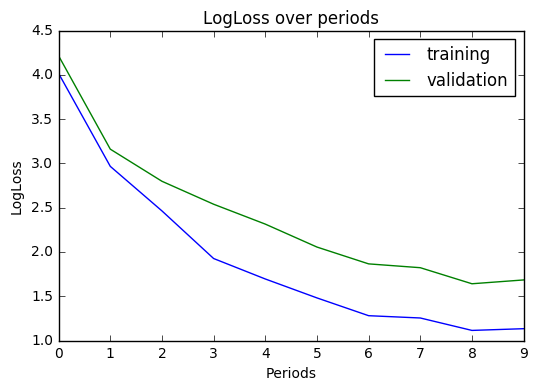

[[385   0   1   5   0   2   4   0   2   1]
 [  0 414   6   3   0   0   0   0   7   0]
 [  0   2 404   5   3   0   0   5   2   1]
 [  1   1   2 397   0   3   0   1   1   2]
 [  1   0   3   0 396   1   2   3   1  13]
 [  1   0   1  20   0 313   1   1   3   0]
 [  1   1   3   1   1   1 375   0   2   0]
 [  0   2   5   3   1   0   0 377   0   5]
 [  0   0   6  12   0   3   3   1 354   3]
 [  1   0   0   6   5   2   0  11   5 390]] (10, 10)


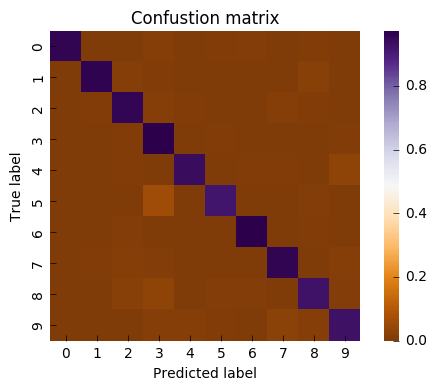

In [14]:
dnn_classifier = train_nn_classification_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=1000,
    batch_size=30,
    hidden_units=[100, 100],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [15]:
mnist_test_df = pd.read_csv('https://storage.googleapis.com/mledu-datasets/mnist_test.csv', sep=',', header=None)

test_targets, test_examples = parse_labels_and_features(mnist_test_df)
display.display(test_examples.describe())

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000703,0.000642,0.000206,0.000002,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022252,0.022494,0.009490,0.000235,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992157,0.992157,0.611765,0.023529,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
predict_test_input_function = create_predict_input_function(test_examples, test_targets, batch_size=100)

test_predictions = dnn_classifier.predict(input_fn=predict_test_input_function)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])

accuracy = metrics.accuracy_score(test_targets, test_predictions)
print('Accuracy on test data: %0.2f' % accuracy)

INFO:tensorflow:Restoring parameters from C:\Users\STRIKE~1\AppData\Local\Temp\tmpg6x4xiaq\model.ckpt-1000
Accuracy on test data: 0.95


Visulize the weights of the first hidden layer

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape:  (784, 100)
100
10


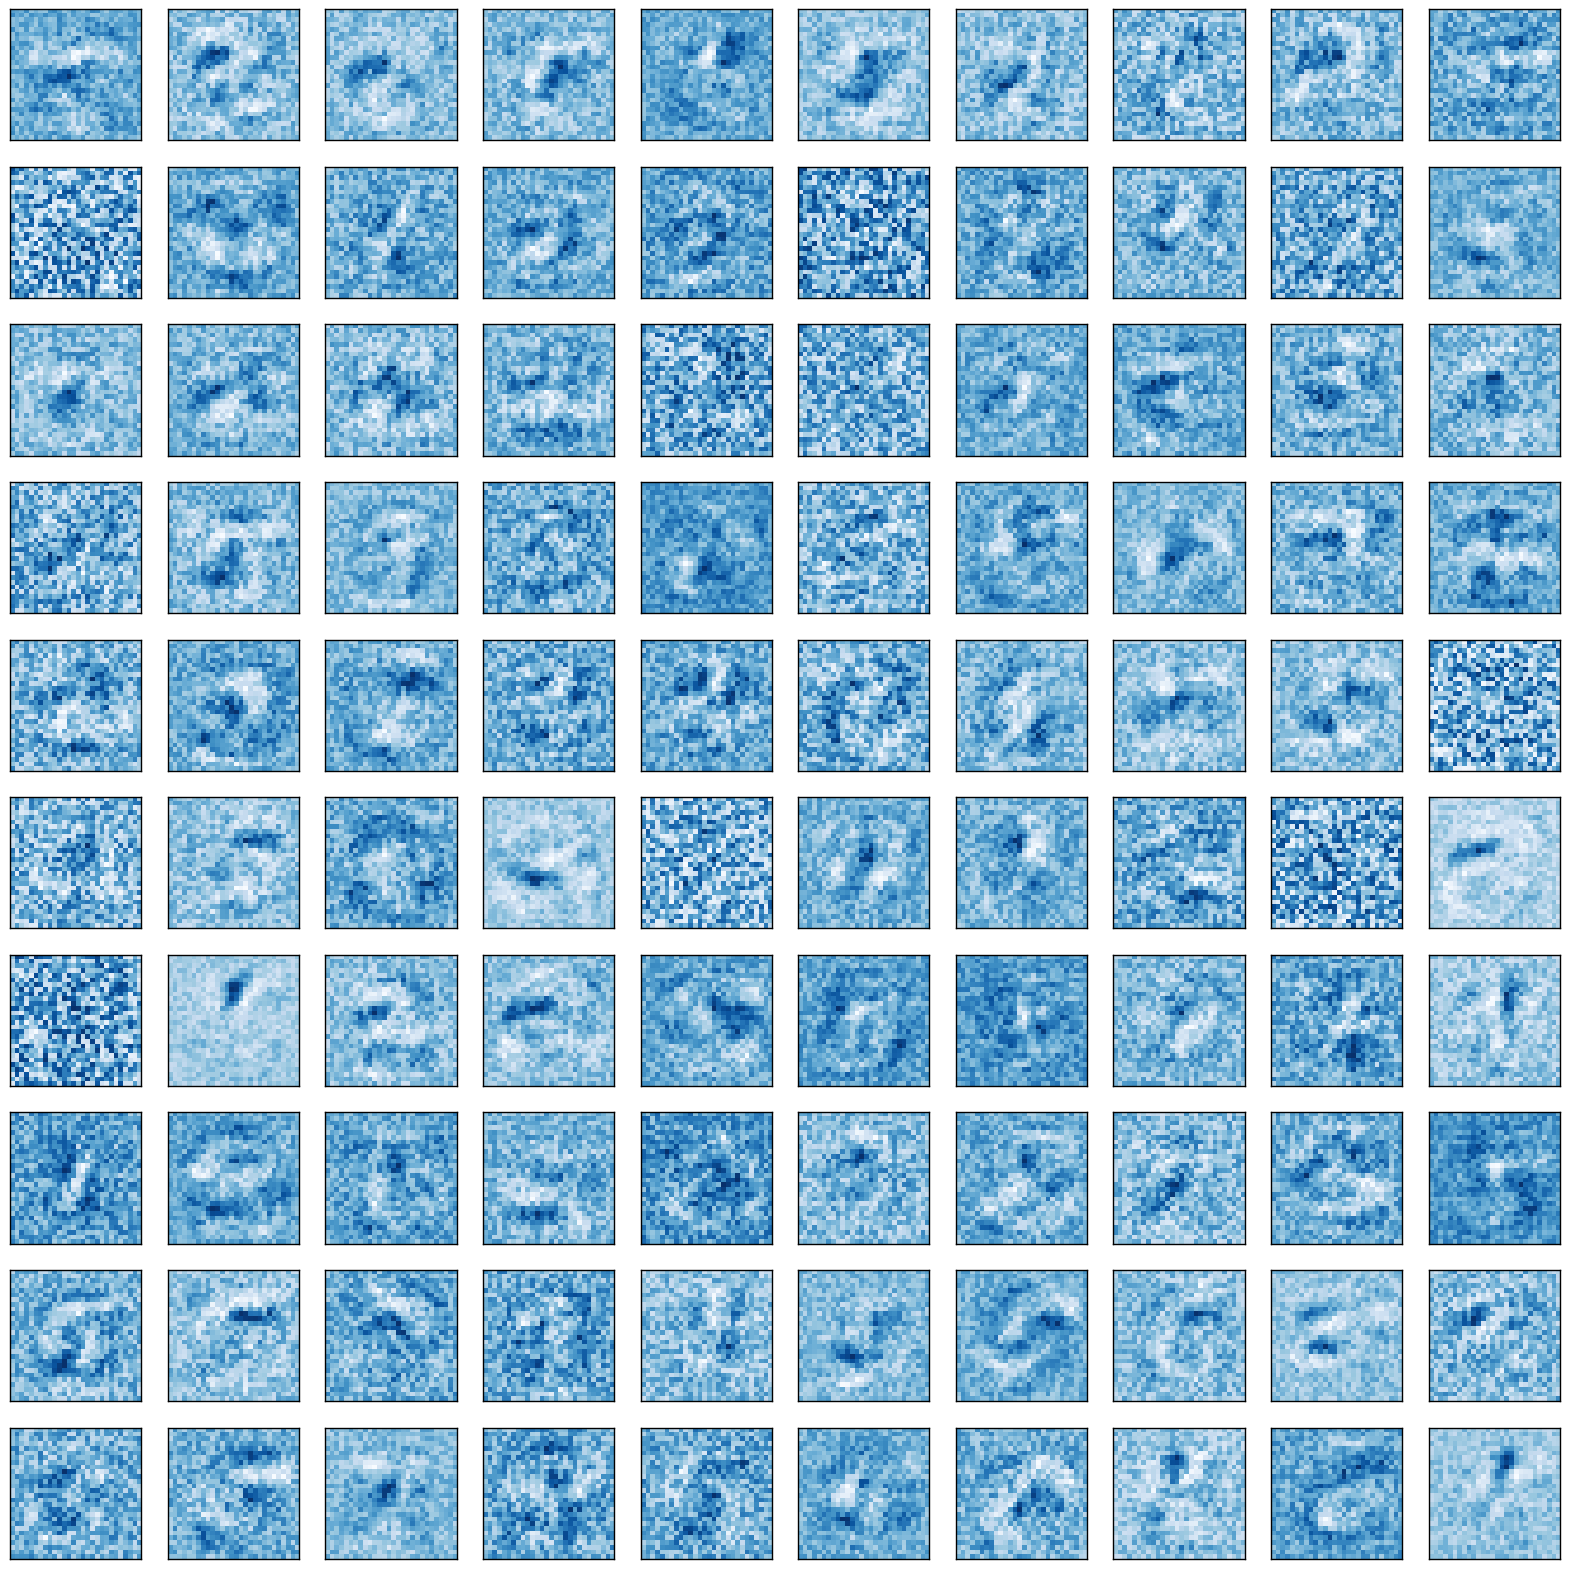

In [24]:
print(dnn_classifier.get_variable_names())

weights0 = dnn_classifier.get_variable_value('dnn/hiddenlayer_0/kernel')

print('weights0 shape: ', weights0.shape)

num_nodes = weights0.shape[1]
print(num_nodes)
num_rows = int(math.ceil(num_nodes/10.0))
print(num_rows)

fig, axes = plt.subplots(num_rows, 10, figsize=(20,2*num_rows))

for coef, ax in zip(weights0.T, axes.ravel()):
    #Weights in coef is reshaped from 1x784 to 28x28
    ax.matshow(coef.reshape(28,28), cmap=plt.cm.Blues_r)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

In [25]:
print(dnn_classifier.get_variable_names())

weights1 = dnn_classifier.get_variable_value('dnn/hiddenlayer_1/kernel')

print('weights1 shape: ', weights1.shape)

num_nodes = weights1.shape[1]
print(num_nodes)
num_rows = int(math.ceil(num_nodes/10.0))
print(num_rows)

fig, axes = plt.subplots(num_rows, 10, figsize=(20,2*num_rows))

for coef, ax in zip(weights1.T, axes.ravel()):
    #Weights in coef is reshaped from 1x784 to 28x28
    ax.matshow(coef.reshape(28,28), cmap=plt.cm.autumn)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights1 shape:  (100, 100)
100
10


ValueError: cannot reshape array of size 100 into shape (28,28)